In [1]:
# Google Colab Only
try:
    import google.colab  # noqa: F401

    %pip install -q dataeval opencv-python-headless
except Exception:
    pass

In [2]:
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np

from dataeval import config
from dataeval.extractors._bovw import BoVWExtractor
from dataeval.flags import ImageStats
from dataeval.quality import Duplicates

config.set_seed(67)  # six seven

In [3]:
def create_textured_image(seed: int, size: int = 128) -> np.ndarray:
    """Create an image with texture patterns that SIFT can detect."""
    rng = np.random.default_rng(seed)

    # Create base with gradient and noise
    x = np.linspace(0, 4 * np.pi, size)
    y = np.linspace(0, 4 * np.pi, size)
    xx, yy = np.meshgrid(x, y)

    # Create pattern with multiple frequency components
    pattern = (
        np.sin(xx * (1 + seed % 3)) * np.cos(yy * (2 + seed % 2))
        + np.sin(xx * 3 + seed) * 0.5
        + rng.random((size, size)) * 0.3
    )

    # Normalize to 0-255
    pattern = ((pattern - pattern.min()) / (pattern.max() - pattern.min()) * 255).astype(np.uint8)

    # Create RGB image (same pattern in all channels with slight variation)
    img = np.stack(
        [pattern, np.roll(pattern, seed % 10, axis=0), np.roll(pattern, seed % 7, axis=1)], axis=0
    )  # Shape: (3, H, W) - channels first

    return img.astype(np.uint8)

In [4]:
def rotate_image(img: np.ndarray, angle: float) -> np.ndarray:
    """Rotates image by any angle"""
    angle = angle % 360

    if angle == 0:
        return img

    # Transpose to HWC for OpenCV
    img_hwc = np.transpose(img, (1, 2, 0))

    # Orthogonal rotations (90, 180, 270)
    if angle % 90 == 0:
        rotate_code = {1: cv2.ROTATE_90_COUNTERCLOCKWISE, 2: cv2.ROTATE_180, 3: cv2.ROTATE_90_CLOCKWISE}
        rotated = cv2.rotate(img_hwc, rotate_code[int((angle // 90) % 4)])

    # Affine rotation (Diagonal)
    else:
        h, w = img_hwc.shape[:2]
        center = (w // 2, h // 2)
        matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

        cos, sin = np.abs(matrix[0, 0]), np.abs(matrix[0, 1])
        new_w, new_h = int(h * sin + w * cos), int(h * cos + w * sin)

        matrix[0, 2] += (new_w - w) / 2
        matrix[1, 2] += (new_h - h) / 2

        rotated = cv2.warpAffine(img_hwc, matrix, (new_w, new_h), borderValue=(128, 128, 128))

    # Transpose back to CHW
    return np.transpose(rotated, (2, 0, 1))

In [5]:
def flip_image(img: np.ndarray, direction: str) -> np.ndarray:
    """Flip image horizontally or vertically"""
    img_hwc = np.transpose(img, (1, 2, 0))
    flipped = cv2.flip(img_hwc, 1) if direction == "horizontal" else cv2.flip(img_hwc, 0)
    return np.transpose(flipped, (2, 0, 1))

In [6]:
images, labels, group_info = [], [], []

experiments = [
    (
        42,
        "Group 1: Orthogonal (D4 Detectable)",
        [(rotate_image, 90, "Rot 90°"), (rotate_image, 180, "Rot 180°"), (flip_image, "horizontal", "Flip H")],
    ),
    (
        63,
        "Group 2: Diagonal (BoVW Only)",
        [(rotate_image, 45, "Rot 45°"), (rotate_image, 135, "Rot 135°"), (rotate_image, 30, "Rot 30°")],
    ),
    (
        89,
        "Group 3: Mixed Rotations",
        [(rotate_image, 90, "Rot 90°"), (rotate_image, 60, "Rot 60°"), (flip_image, "vertical", "Flip V")],
    ),
]

for seed, desc, transforms in experiments:
    start_idx = len(images)
    base_img = create_textured_image(seed=seed)

    images.append(base_img)
    labels.append(f"Original (Seed {seed})")

    for func, arg, suffix in transforms:
        images.append(func(base_img, arg))
        labels.append(f"Seed {seed} - {suffix}")

    group_info.append((desc, start_idx, len(images) - 1))

start_idx = len(images)
unique_seeds = [777, 888, 999]

for i, seed in enumerate(unique_seeds):
    images.append(create_textured_image(seed=seed))
    labels.append(f"Unique {i + 1}")

group_info.append(("Group 4: Unique Images", start_idx, len(images) - 1))

print(f"Created {len(images)} test images\n" + "=" * 60)
for desc, start, end in group_info:
    print(f"{desc:<40} (indices {start}-{end})")
print("=" * 60)

for i, label in enumerate(labels):
    print(f"  [{i:2d}] {label}")

Created 15 test images
Group 1: Orthogonal (D4 Detectable)      (indices 0-3)
Group 2: Diagonal (BoVW Only)            (indices 4-7)
Group 3: Mixed Rotations                 (indices 8-11)
Group 4: Unique Images                   (indices 12-14)
  [ 0] Original (Seed 42)
  [ 1] Seed 42 - Rot 90°
  [ 2] Seed 42 - Rot 180°
  [ 3] Seed 42 - Flip H
  [ 4] Original (Seed 63)
  [ 5] Seed 63 - Rot 45°
  [ 6] Seed 63 - Rot 135°
  [ 7] Seed 63 - Rot 30°
  [ 8] Original (Seed 89)
  [ 9] Seed 89 - Rot 90°
  [10] Seed 89 - Rot 60°
  [11] Seed 89 - Flip V
  [12] Unique 1
  [13] Unique 2
  [14] Unique 3


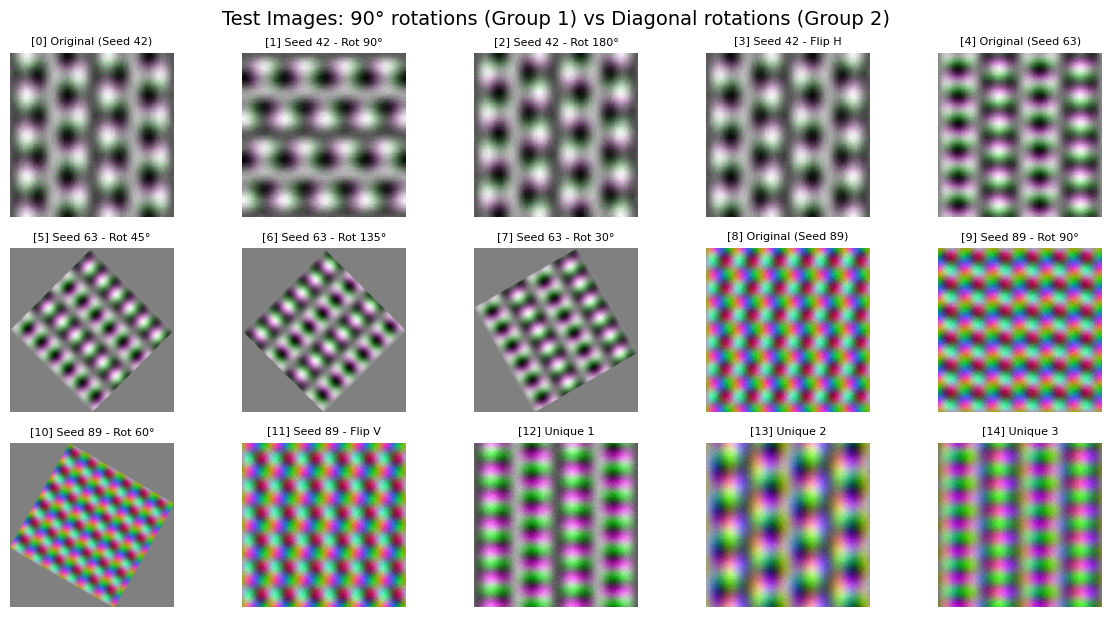

In [7]:
# Visualize the test images
fig, axes = plt.subplots(3, 5, figsize=(12, 6))
axes = axes.flatten()

for i, (img, label) in enumerate(zip(images, labels)):
    if i < len(axes):
        # Convert CHW to HWC for display
        img_display = np.transpose(img, (1, 2, 0))
        axes[i].imshow(img_display)
        axes[i].set_title(f"[{i}] {label}", fontsize=8)
        axes[i].axis("off")

# Hide empty subplots
for i in range(len(images), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.suptitle("Test Images: 90° rotations (Group 1) vs Diagonal rotations (Group 2)", y=1.02, fontsize=14)
plt.show()

In [8]:
# Run D4 hash-based detection
start_time = time.time()

d4_detector = Duplicates(flags=ImageStats.HASH_DUPLICATES_D4)
d4_results = d4_detector.evaluate(images)

d4_time = time.time() - start_time
print(f"D4 Hash Detection completed in {d4_time:.3f} seconds")

D4 Hash Detection completed in 0.034 seconds


In [9]:
print("\n=== D4 Hash Results ===")
print("\nNear duplicates (perceptual similarity):")
if d4_results.items.near:
    for group in d4_results.items.near:
        indices = list(group.indices)
        methods = sorted(group.methods)
        print(f"  Indices: {indices}")
        print(f"    Methods: {methods}")
        print(f"    Labels: {[labels[int(i)] for i in indices]}")
        print()


=== D4 Hash Results ===

Near duplicates (perceptual similarity):
  Indices: [0, 1, 2, 3]
    Methods: ['dhash_d4', 'phash_d4']
    Labels: ['Original (Seed 42)', 'Seed 42 - Rot 90°', 'Seed 42 - Rot 180°', 'Seed 42 - Flip H']

  Indices: [8, 9, 11]
    Methods: ['dhash_d4', 'phash_d4']
    Labels: ['Original (Seed 89)', 'Seed 89 - Rot 90°', 'Seed 89 - Flip V']



In [10]:
# Run BoVW-based detection
bovw_extractor = BoVWExtractor(vocab_size=128)  # Smaller vocab for small dataset

start_time = time.time()

bovw_detector = Duplicates(
    flags=ImageStats.NONE,  # Skip hash computation
    feature_extractor=bovw_extractor,
    cluster_threshold=1.25,
)
bovw_results = bovw_detector.evaluate(images)

bovw_time = time.time() - start_time
print(f"BoVW Detection completed in {bovw_time:.3f} seconds")

BoVW Detection completed in 0.559 seconds


In [11]:
print("\n=== BoVW Results ===")
print("\nNear duplicates (embedding similarity):")
if bovw_results.items.near:
    for group in bovw_results.items.near:
        indices = list(group.indices)
        methods = sorted(group.methods)
        print(f"  Indices: {indices}")
        print(f"    Methods: {methods}")
        print(f"    Labels: {[labels[int(i)] for i in indices]}")
        print()
else:
    print("  No near duplicates found")


=== BoVW Results ===

Near duplicates (embedding similarity):
  Indices: [0, 1, 2, 3]
    Methods: ['cluster']
    Labels: ['Original (Seed 42)', 'Seed 42 - Rot 90°', 'Seed 42 - Rot 180°', 'Seed 42 - Flip H']

  Indices: [4, 5, 6, 7]
    Methods: ['cluster']
    Labels: ['Original (Seed 63)', 'Seed 63 - Rot 45°', 'Seed 63 - Rot 135°', 'Seed 63 - Rot 30°']

  Indices: [8, 9, 10]
    Methods: ['cluster']
    Labels: ['Original (Seed 89)', 'Seed 89 - Rot 90°', 'Seed 89 - Rot 60°']



In [12]:
print("\n=== Performance Summary ===")
print("\nExecution Time:")
print(f"  D4 Hashes:  {d4_time:.3f}s")
print(f"  BoVW:       {bovw_time:.3f}s ({bovw_time / d4_time:.1f}x slower)")

print("\nDetection Results:")
print(f"  {'Method':<15} {'Exact':<10} {'Near Groups':<15}")
print(f"  {'-' * 40}")

d4_exact = len(d4_results.items.exact) if d4_results.items.exact else 0
d4_near = len(d4_results.items.near) if d4_results.items.near else 0
print(f"  {'D4 Hashes':<15} {d4_exact:<10} {d4_near:<15}")

bovw_exact = len(bovw_results.items.exact) if bovw_results.items.exact else 0
bovw_near = len(bovw_results.items.near) if bovw_results.items.near else 0
print(f"  {'BoVW':<15} {bovw_exact:<10} {bovw_near:<15}")


=== Performance Summary ===

Execution Time:
  D4 Hashes:  0.034s
  BoVW:       0.559s (16.6x slower)

Detection Results:
  Method          Exact      Near Groups    
  ----------------------------------------
  D4 Hashes       0          2              
  BoVW            0          3              


In [13]:
### TEST ASSERTION CELL ###
# D4 hashes should detect 90° rotations but NOT diagonal rotations
assert d4_results.items.near is not None, "D4 should find some near duplicates"

# BoVW should never report exact duplicates (embeddings are approximate)
assert bovw_results.items.exact is None, "BoVW should not report exact duplicates"

# BoVW should detect more groups than D4 (because it catches diagonal rotations)
bovw_near_count = len(bovw_results.items.near) if bovw_results.items.near else 0
d4_near_count = len(d4_results.items.near) if d4_results.items.near else 0

print(f"\nD4 detected {d4_near_count} near-duplicate groups")
print(f"BoVW detected {bovw_near_count} near-duplicate groups")
print("\nBoVW detects diagonal rotations that D4 misses!")


D4 detected 2 near-duplicate groups
BoVW detected 3 near-duplicate groups

BoVW detects diagonal rotations that D4 misses!
